In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# DCT hyoer-parameter
T = 8
K = 8
ch = 3

In [24]:
# BGR -> YCbCr
def BGR2YCbCr(img):
    h, w = img.shape[:2]
    
    ycbcr = np.zeros([h,w,3], dtype=np.float32)
    
    ycbcr[..., 0] = 0.2990 * img[..., 2] + 0.587 * img[..., 1] + 0.1140 * img[..., 0]
    ycbcr[..., 1] = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] +128.
    ycbcr[..., 2] = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.
    
    return ycbcr

In [58]:
# YCbCr -> BGR
def YCbCr2BGR(ycbcr):
    h, w = img.shape[:2]
    
    out = np.zeros([h, w, ch], dtype= np.float32)
    out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.4020
    out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
    out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

In [59]:
# DCT weight
def DCT_w(x, y, u, v):
    cu =1.
    cv =1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    f =  ((2 * cu * cv / T) * np.cos((2 * x + 1) * u * theta) * np.cos((2 * y + 1) * v * theta)) 
    return f

In [60]:
# DCT
def DCT(img):
    h, w = img.shape[:2]
    
    F = np.zeros((h, w, ch), dtype=np.float32)
    
    for c in range(ch):
        for yi in range(0, h, T):
            for xi in range(0, w, T):
                for v in range(T):
                    for u in range(T):
                        for y in raneg(T):
                            for x in range(T):
                                F[v+yi, u+xi, c] += img[y+yi, x+xi, c] * DCT_w(x,y,u,v)
    return F

In [61]:
# IDCT
def DCT(F):
    h, w = F.shape[:2]
    
    out = np.zeros((h, w, ch), dtype=np.float32)
    
    for c in range(ch):
        for yi in range(0, h, T):
            for xi in range(0, w, T):
                for v in range(T):
                    for u in range(T):
                        for y in range(K):
                            for x in range(K):
                                out[y+yi, x+xi, c] += F[v+yi, u+xi, c] * DCT_w(x,y,u,v)
                    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

In [62]:
# Quantization
def quantization(F):
    h, w = F.shape[:2]
    
    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                (12, 12, 14, 19, 26, 58, 60, 55),
                (14, 13, 16, 24, 40, 57, 69, 56),
                (14, 17, 22, 29, 51, 87, 80, 62),
                (18, 22, 37, 56, 68, 109, 103, 77),
                (24, 35, 55, 64, 81, 104, 113, 92),
                (49, 64, 78, 87, 103, 121, 120, 101),
                (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    
    for ys in range(0, h, T):
        for xs in range(0, w, T):
            for c in range(ch):
                F[ys: ys + T, xs: xs + T, c] = np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q
            
    return F

In [63]:
# JPEG without Hufman coding
def JPEG(img):
    # BGR -> YCbCr
    ycbcr = BGR2YCbCr(img)
    # DCT
    F = DCT(ycbcr)
    # Quantization
    F = quantization(F)
    # YCbCr -> BGR
    out = YCbCr2BGR(ycbcr)
    return out

In [64]:
# MSE 
def MSE(img1, img2):
    h, w = img1.shape[:2]
    mse = np.sum((img1 - img2) ** 2) / (h * w * ch)
    return mse

In [65]:
# PSNR
def PSNR(mse, vmax=255):
    psnr = 10 * np.log10(vmax * vmax / mse)
    return psnr

In [66]:
# bitrate
def BITRATE():
    bitrate = 1. * T * K * K / T / T
    return bitrate

In [67]:
img = cv2.imread("../assets/imori.jpg").astype(np.float32)
# JPEG
out = JPEG(img)

# MSE
mse = MSE(img, out)
print("MSE :", mse)

# PSNR
psnr = PSNR(mse)
print("PSNR :", psnr)

# bitrate
bitrate = BITRATE()
print("BITRATE :", bitrate)

MSE : 0.3201904296875
PSNR : 53.07672013909312
BITRATE : 8.0


True

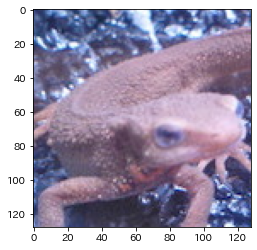

In [71]:
plt.imshow(out[:,:,::-1])
# Save
cv2.imwrite("../assets/imori_bit.jpg", out)